# Recipes Tutorial

This notebook is a quick tutorial on the different types of Recipes in the contexts of Plots.jl, and what makes them so great.

Different recipe types exist for different reasons but the main points are:
- Allow users to define plot routines for types that are not natively supported by Plots.jl.
- Allow users to define plot routines without depending on Plots.jl.


###### How can we write plot routines without depending on Plots.jl?
- Use RecipesBase.jl, which contains handy macros like @recipe, @userplot, etc.
  
RecipesBase.jl is a minimal package - it has no dependencies! This means our analysis packages can have shared, custom plot routines without any of the heavy dependencies. 




Note that most of the information here comes from two sources:
 - [Plots.jl documentation](http://docs.juliaplots.org/latest/recipes/).
 - [RecipesBase.jl documentation](http://juliaplots.org/RecipesBase.jl/stable/).

In [1]:
using Pkg 
Pkg.activate(@__DIR__)


using RecipesBase
using Plots
using Colors
using Measures
using Distributions

  Activating environment at `~/Repos/RecipesTutorial/Project.toml`


# Type Recipes

- `@recipe function f(::Type{T}, val::T) where{T} end`
- These define a mapping between custom types, to something that Plots.jl supports.
- They basically tell Plots what to do when it sees your custom type.


Lets start with some fake data

In [2]:
data = rand(100);

say we wrap this data in a `ResultsWrapper`.

In [3]:
struct ResultsWrapper
    results::Vector
end

In [4]:
result = ResultsWrapper(cumsum(data))

ResultsWrapper([0.3575958386072837, 1.3329708906871933, 1.6750210950535978, 1.7128388409567905, 2.307031229929968, 2.3569842985189635, 3.3524396393132365, 3.4561739576445616, 3.60524501794778, 4.496610542539468  …  45.692211819527515, 46.27791796660458, 46.396789691115984, 46.751750399692206, 47.52276556917633, 47.57570348271772, 48.17215270892519, 48.62236067108332, 49.589386586501746, 49.8353029228221])

If we try to plot the data, we will get an error, because `Plots.jl` does not support the custom type `ResultsWrapper`.

In [5]:
plot(result)

LoadError: Cannot convert ResultsWrapper to series data for plotting

This is where the Type Recipe comes in, we need to tell `Plots.jl`, what to do when it sees our custom type. `RecipesBase.jl` gives the handy `@recipe` macro to do that. This says when we see the ResultsWrapper type, pull out the `results` field for plotting.

In [6]:
@recipe f(::Type{ResultsWrapper}, rw::ResultsWrapper) = rw.results

Now we have told `Plots.jl` how to handle our custom type, so now we can call `plot` on that type.

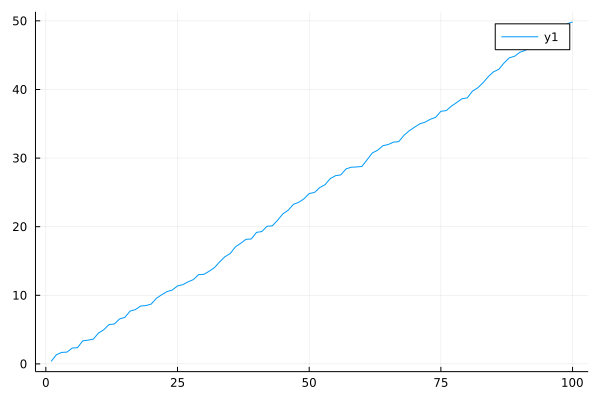

In [7]:
plot(result)

Type recipes are applied recursively so if we have some data wrapped up in several types we can define a type recipe for each wrapper and when we call plot on the top layer, we will be able to plot the data from lower layers.

# User Recipes

These give users a way to define plot routines for custom types. When a user calls `plot(MyType)`, a pre-defined routine will be applied.


They can also be used to define custom vsiualisation without wanting to plot custom types. 

**Note some tips about syntax**:

`plotattributes` is a dictionary that contains attributes of a plot (title, label, color etc.)

`Attribute → value`, set the plot attribute to value as default
 - `haskey(plotattributes, :attr) || plotattributes[:attr] = val`

`Attribute := value`, force the plot attribute to value irrespective of user input.
- `plotattributes[:attr] = val`



### User Recipe for custom type

In [8]:
# define a custom type.
struct FunShape
    x::Vector
    y::Vector
    radius::Vector
end

In [9]:
# generate the data for the type 
n = 500
angle = 0:(12*2*pi/n):(12*2*pi)
radius = 0.01:0.99/n:1


x = radius .* cos.(angle)
y = radius .* sin.(angle)

result = FunShape(x, y, radius);

Can we just call plot on `result`? 

In [10]:
plot(result)

LoadError: Cannot convert FunShape to series data for plotting

We need a user recipe for this custom type.

In [11]:
@recipe function f(shape::FunShape) # Note that the name of the function is irrelavant.
    # set the default labels on the axis
    xguide --> "x"
    yguide --> "y"
    zguide --> "radius"
    
    # we use @series begin to start a new series on the plot.
    @series begin
        label --> ""
        # line style
        linestyle := :solid
        # set the default to be red
        linecolor --> :red
        # set the default series type
        seriestype --> :path
        # we return the data we want for the series, in this case we need the x, y and radius fields.
        return shape.x, shape.y, shape.radius
    end
end
        

Now we can plot the fun shape!

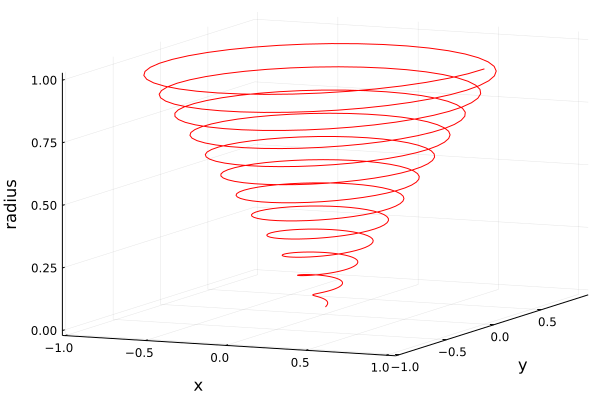

In [12]:
plot(result)

and we can pass any plot kwargs like we would be able to for any `plot` call. How great. Notice that that the color and legend can be changed in the call, but we can't change the line style to `:dash`. This shows the difference between the `-->` (set a default attribute) and `:=` (force an attribute) syntax. 

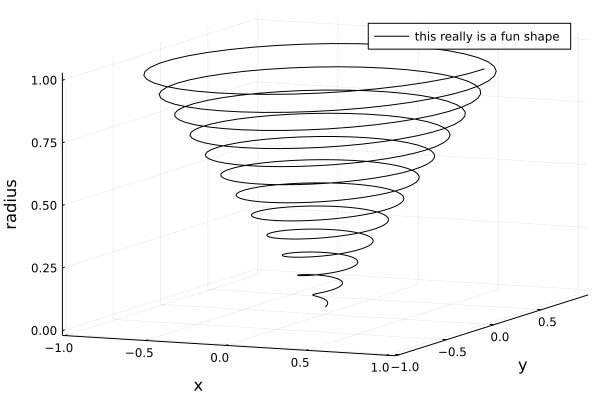

In [13]:
plot(result,
    linecolor = :black,
    label = "this really is a fun shape",
    linestyle = :dash, # we forced this attribute in the recipe, so it's ignored in the call.
)

### Another way to use User Recipes

We can use user recipes to create custom plot routines without any custom types. We just need to make sure that the data we input is supported by the Plots.jl ecosystem (or we need to write a type recipe to support the custom type).

To make this easy, RecipesBase.jl has the `@userplot` macro which expands to
@userplot MyPlot

```
mutable struct MyPlot
    args
end
export myplot, myplot!
myplot(args...; kw...) = plot(MyPlot(args); kw...)
myplot!(args...; kw...) = plot!(MyPlot(args); kw...)
```

In [14]:
@userplot FunShapePlot
@recipe function f(FSP::FunShapePlot) # the type annotation must match the name after `@userplot`
    x,y,radius = FSP.args
    
    xguide --> "x"
    yguide --> "y"
    zguide --> "radius"
    
    # we use @series begin to start a new line on the plot.
    @series begin
        label --> ""
        # line style
        linestyle := :solid
        # set the default to be red
        linecolor --> :red
        # we return the data we want for the series, in this case we need the x, y and radius fields.
        x, y, radius
    end
end

In [15]:
methods(@userplot FunShapePlot)

# 2 methods for generic function "funshapeplot!":
[1] funshapeplot!(plt::AbstractPlot, args...; kw...) in Main at /Users/iangoddard/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:359
[2] funshapeplot!(args...; kw...) in Main at /Users/iangoddard/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:358

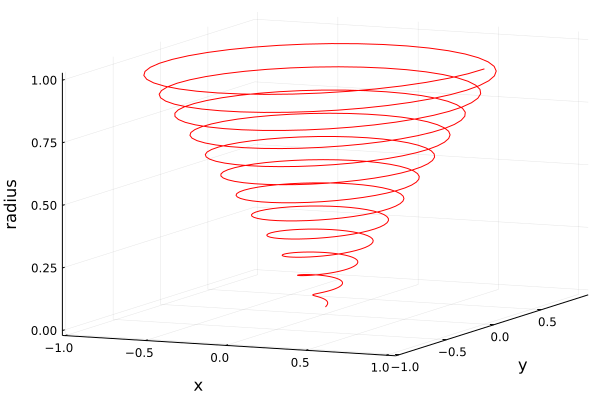

In [16]:
#  This doesn't act on the custom `FunShape` type, but on types that Plots.jl natively supports.
funshapeplot(x, y, radius)

this looks very similar to the previous user recipe, but it is subtly different in that it does not define a type recipe for the type `FunShape`.

Also, this allows us to call `FunShapePlot()`, so it gives context to what we're plotting via the function signature.

In theory we could pass in any x,y,z that plots will support. Since we define a type recipe for `ResultsWrapper` maybe that will work too? 

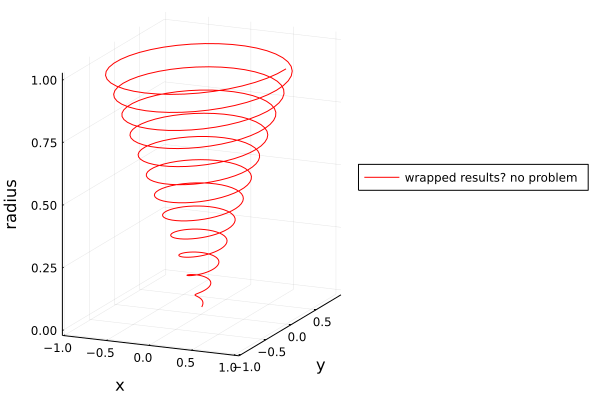

In [17]:
funshapeplot(
    ResultsWrapper(x), ResultsWrapper(y), ResultsWrapper(radius);
    label = "wrapped results? no problem",
    legend = :outerright
)

Ah yeah it does - **This is because the recipes are run recursively until plots finds a type that it supports**.

oh kwargs work as well. Nice.

# Plot Recipes

- `@recipe function f(::Type{Val{:myplotrecipename}}, plt::AbstractPlot; ...) end`
- These recipes are called after input data has been processed, but before the plot is created. So we can use them to build custom layouts on processed data. 
- Given some input data, lay it out on different subplots in a pre-defined way. A good example would be given some input data, show me the data on a linear axis, and a log axis. 

In [18]:
@recipe function f(::Type{Val{:ScaleHistograms}}, plt::AbstractPlot)
    layout := (1, 2)

    for (i, axis_scale) in enumerate([:linear, :log10])
        @series begin
            subplot :=i
            seriestype := :histogram
            yscale := axis_scale
            yguide := string(axis_scale)
            label := ""
        end
    end
end


Here we make use of the `@shorthands` macro which creates
convenience methods and exports them. 


`@shorthands CustomPlot`

```
export CustomPlot, CustomPlot!
CustomPlot(args...; kw...) = plot(args...; kw..., seriestype = :CustomPlot)
CustomPlot!(args...; kw...) = plot!(args...; kw..., seriestype = :CustomPlot)
```

In [19]:
@shorthands ScaleHistograms

ScaleHistograms! (generic function with 1 method)

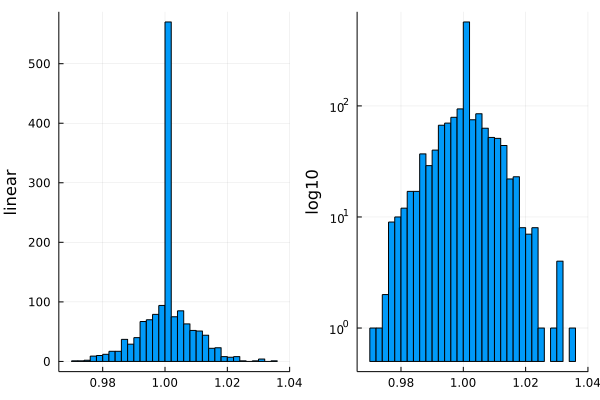

In [20]:
ScaleHistograms(
    reduce(vcat, [abs.(rand(Normal(1, 0.01) , 1000)), ones(500)...])
)

Or you could create some shapes on subplots and lay them out in a nice way. 

In [21]:
@recipe function f(::Type{Val{:SomeSquares}}, plt::AbstractPlot)
     layout := (2, 2)
     for i in 1:3
        @series begin
            if i == 1 
                fillcolor := colors[1]
            else
                fillcolor := colors[2]
            end
            fillrange := 1000
            seriestype := :path
            subplot := i
        end
    end
end

In [22]:
@shorthands SomeSquares
colors = [colorant"#4F98CB", colorant"#00315A"];

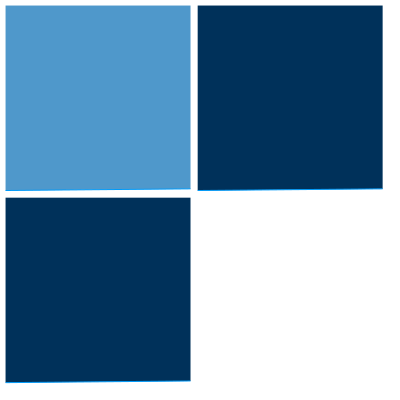

In [23]:
SomeSquares(1:10, 1:10, xticks = [], yticks = [],
    xaxis = :false, yaxis = :false, size = (400, 400),
    margin = -6mm, label = "")

# Series Recipe

`@recipe function f(::Type{Val{:myseriesrecipename}}, x, y, z; ...) end`
- A way to explain to explain this: 

    - A histogram =>bar chart , and a bar chart => series of lines.
    
        - A plotting package only needs to be able to plot lines and polygons to plot histograms. 
        
    - Writing a series recipe lets us split up the complexity of creating a histogram into subcomponents. 
    
        - Find the bins and edges.
        
        - Plot a bar chart (a bar chart is itself a recipe to plot a series of lines).
        
- Fundamentally: A series recipe lets us create series types, so we can create custom visualisations for arbitrary data. An easy example of this is the ordered bar chart recipe below.



By defining the series recipe for `orderedbar` we can create ordered bar charts on any input data (given that inner functions can handle the types). Note that this is doable with user recipes, but it's more cumbersome to write.

In [24]:
#=
`y` is always populated, think when you call plot(rand(10)), you see the vector values on the y axis, not x or z. 
`x` and `z` are populated if they are specified, so plot(rand(10), rand(10)) would populate x and y. 

=#

@recipe function f(::Type{Val{:orderedbar}}, x, y, z)
    x_loc, y_loc = (1:length(y), sort(y))
    seriestype := :bar
    x := x_loc
    y := y_loc
end


    
@shorthands orderedbar

orderedbar! (generic function with 1 method)

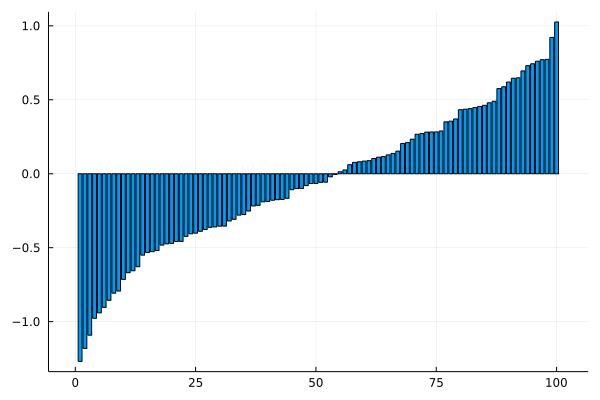

In [25]:
plot(rand(Normal(0, 0.5), 100), seriestype = :orderedbar, legend = :false)

And we also can use the shorthand method

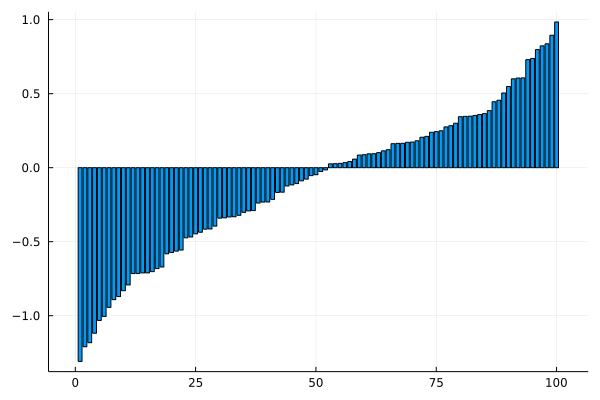

In [26]:
orderedbar(rand(Normal(0, 0.5), 100), legend = false)

And it works with our Custom types! again due to the recursive nature of recipes.

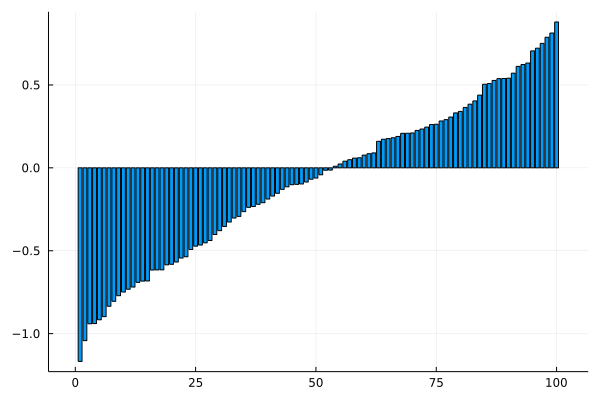

In [27]:
plot(ResultsWrapper(rand(Normal(0, 0.5), 100)),
    seriestype = :orderedbar,
    legend = :false
)